In [75]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
import PIL
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from io import BytesIO
import svgwrite
import cv2
import svgwrite
from IPython.display import SVG, display


In [76]:
icon_name = "hireIconPreEdit"

(459, 545, 4)


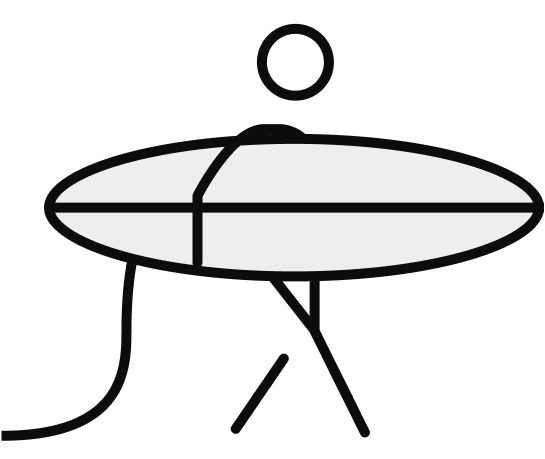

In [77]:

image = PIL.Image.open(f'icons/{icon_name}.png')
data = np.asarray(image)
print(data.shape)
image


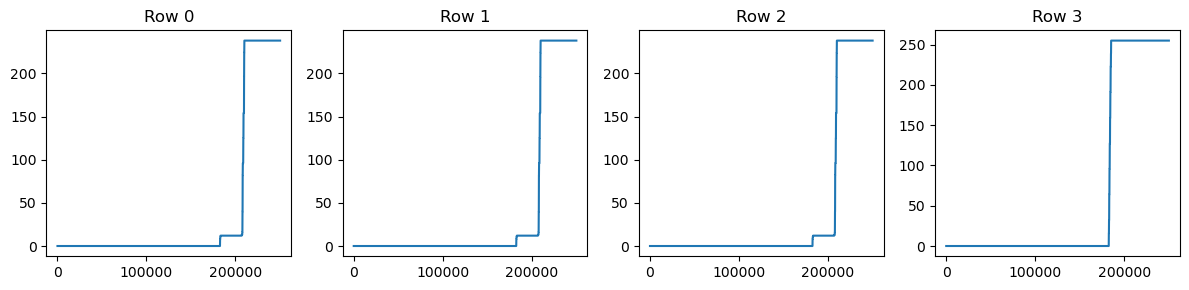

In [78]:
flat_arr = data.reshape((data.shape[0]*data.shape[1], 4))
arr = flat_arr.T

# create a 2x2 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

# loop through the rows of arr and plot each row in a subplot
for i, row in enumerate(arr):
    ordered = np.sort(row)
    ax = axs[i]  # select the correct subplot for this row
    ax.plot(ordered)
    ax.set_title(f"Row {i}")  # set the title of the subplot to the row number

# adjust the layout of the subplots and show the figure
fig.tight_layout()
plt.show()



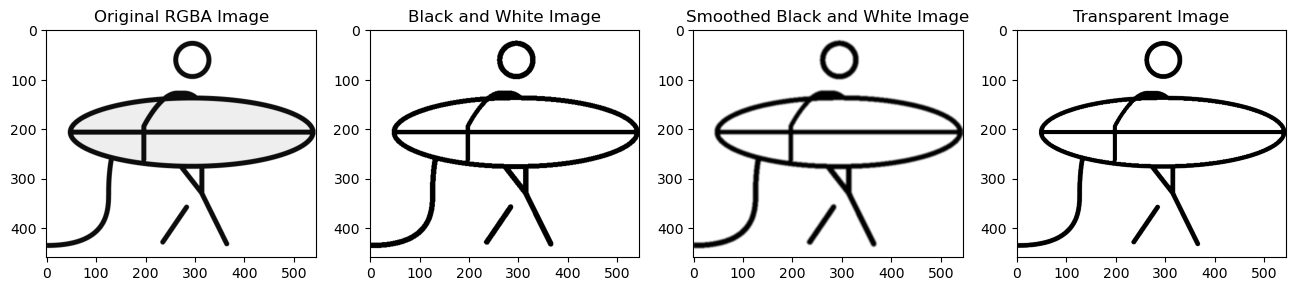

In [79]:
smooth = False

# extract the RGB components
rgb_data = data[:, :, :3]
a_data = np.expand_dims(data[:, :, -1],-1)

# create a boolean mask for pixels with conditions
# low_rgb_mask = (rgb_data < 100).all(axis=-1) #& (rgb_data > 20).all(axis=-1)
low_rgb_mask = (rgb_data < 20).all(axis=-1) & (a_data > 0.5).all(axis=-1)

# create a new array for the black and white image
bw_data = np.zeros((data.shape[0], data.shape[1]), dtype=np.uint8)

# set pixels with low RGB values to black and all others to white
bw_data[low_rgb_mask] = 0
bw_data[~low_rgb_mask] = 255

# Apply Gaussian blur to smooth the image
smoothed_bw_data = cv2.GaussianBlur(bw_data, (7, 7), 0)

if smooth:
    # create a new RGBA image from the smoothed black and white image, preserving the original alpha channel
    final_product = np.zeros((smoothed_bw_data.shape[0], smoothed_bw_data.shape[1], 4), dtype=np.uint8)
    final_product[:, :, 0] = smoothed_bw_data
    final_product[:, :, 1] = smoothed_bw_data
    final_product[:, :, 2] = smoothed_bw_data
    final_product[:, :, 3] = data[:, :, 3]

else:
    final_product = np.zeros((smoothed_bw_data.shape[0], smoothed_bw_data.shape[1], 4), dtype=np.uint8)
    final_product[:, :, 0] = bw_data
    final_product[:, :, 1] = bw_data
    final_product[:, :, 2] = bw_data
    final_product[:, :, 3] = data[:, :, 3]

# set the alpha channel to zero for all white pixels
white_pixels = (final_product[:, :, :3] == 255).all(axis=-1)
final_product[white_pixels, 3] = 0

# plot the original RGBA image, the black and white image, the smoothed black and white image, and the transparent image side by side
fig, axs = plt.subplots(ncols=4, figsize=(16, 4))
axs[0].imshow(data)
axs[0].set_title("Original RGBA Image")
axs[1].imshow(bw_data, cmap="gray")
axs[1].set_title("Black and White Image")
axs[2].imshow(smoothed_bw_data, cmap="gray")
axs[2].set_title("Smoothed Black and White Image")
axs[3].imshow(final_product)
axs[3].set_title("Transparent Image")
plt.show()


True

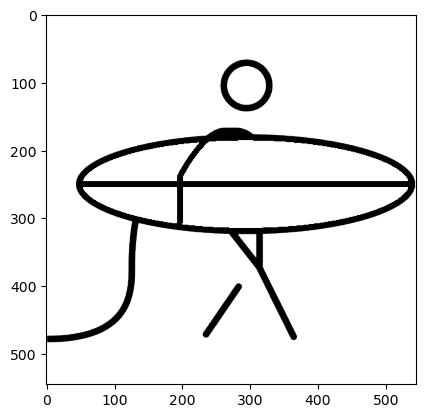

In [83]:


# Make the image square
height, width = final_product.shape[:2]
size = max(width, height)
square_rgba_bw_data = np.zeros((size, size, 4), dtype=np.uint8)
square_rgba_bw_data[:, :, 3] = 0  # Set alpha channel to 0 (transparent) for all pixels

if height > width:
    left_border_width = int((size-width)/2)
    right_border_width = (size - width) - left_border_width 
    square_rgba_bw_data[:height, left_border_width:size-right_border_width] = final_product

elif width > height:
    top_border_height = int((size-height)/2)
    bottom_border_height = (size - height) - top_border_height 
    square_rgba_bw_data[bottom_border_height:size - top_border_height, :width] = final_product
    

plt.imshow(square_rgba_bw_data)

# Save the square RGBA image as a PNG
cv2.imwrite(f'icons/{icon_name}_edited.png', square_rgba_bw_data)
